# Набор данных

**Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии**

Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

## Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
from google.colab import files  # чтобы загружать файлы в облако через проводник

import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации

import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
from sklearn.preprocessing import MinMaxScaler # Объект Нормализации от Scikit-learn

## Считываем файл в DataFrame



метод `.read_csv(path,delimiter)`

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_cat_num.csv', delimiter = ',')
df

Make  Model  Year  Style  Distance  Engine_capacity(cm3)  Fuel_type  \
0        40     92  2011      4  195000.0                1800.0          2   
1        32     62  2014     11  135000.0                1500.0          0   
2        32     71  2012     11  110000.0                1500.0          0   
3        28     23  2006     11  200000.0                1600.0          3   
4        23    124  2000      5  300000.0                2200.0          0   
...     ...    ...   ...    ...       ...                   ...        ...   
32069    42     88  2016     10   88000.0                1800.0          4   
32070    19     53  2002      3  225000.0                1800.0          3   
32071     6     77  2015     11   89000.0                1500.0          0   
32072    22     10  2006      1  370000.0                2000.0          0   
32073    32     62  2006      6  300000.0                1500.0          0   

       Transmission  Price(euro)       km_year  
0                 1       7750.0  17727.272727  
1                 0       8550.0  16875.000000  
2                 0       6550.0  11000.000000  
3                 0       4100.0  12500.000000  
4                 0       3490.0  13636.363636  
...             ...          ...           ...  
32069             1      11500.0  14666.666667  
32070             0       4400.0  11250.000000  
32071             0       7000.0  12714.285714  
32072             0       4000.0  23125.000000  
32073             0       4000.0  18750.000000  

[32074 rows x 10 columns]

Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

# Линейная Регрессия

In [ ]:
from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

**Считываем данные, разбиваем на тестовую и тренировочную, нормализуем**

In [ ]:
df_num = df[num_columns].copy() # берем, например только числовые данные

# не забываем удалить целевую переменную цену из признаков
X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

# разбиваем на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# нормализуем
scaler  = MinMaxScaler()
scaler.fit(X_train)  # для тренировочных сначала "обучаем"
X_train = scaler.transform(X_train) # потом преобразуем  transform
X_test  = scaler.transform(X_test)  # для тестовых - просто transform

In [ ]:
def weights_vis(B, B0, features_names):
    """Модифицированная функция для отрисовки весов.
    Входные переменные:
    ===========
    B: веса признаков
    B0: смещение
    features_names: список названий признаков
    """
    numbers = np.arange(0,len(features_names)+1) # создаем массив от 0 до количество признаков
    weights = np.hstack([B0,B]) #объединяем смещение и веса признаков


    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=1200,
                height=600,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = np.hstack(['b0', features_names]),
                                         )
                )

    fig.show()

In [ ]:
def print_stem(y, label, marker):
    markerline, stemlines, baseline = plt.stem(y, markerfmt=marker,label = label,use_line_collection = True, )
    markerline.set_markerfacecolor('none')

# Регуляризация Линейной Регрессии

In [ ]:
from sklearn.linear_model import Lasso # L1-регуляризация
from sklearn.linear_model import Ridge # L2-регуляризация

## Подготовим несколько функций для анализа обученной модели

**вытаскивание коэффициентов из модели**

In [ ]:
def get_coefs (model):
    """Берем веса как атрибуты обученной модели.
    Входные переменные:
    ===========
    model: обученная модель
    """
    B0=model.intercept_
    B=model.coef_
    return B0, B

**написание модели**

In [ ]:
def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)

**оценка метрик**

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

## **Lasso**

In [ ]:
#@title Регуларизация Lasso { run: "auto" }
#@markdown ### Константа Регуларизации
alpha=241.01 #@param {type:"slider", min:0.01, max:250, step:1}

model = Lasso(alpha=alpha,max_iter=10000 )

model.fit(X_train, y_train)

B0, B = get_coefs(model)

features_names = list(num_columns)
print_model(B0,B,features_names)

y_predict=model.predict(X_test)

print('\n')
print(f"r2 на тестовой выборке: {calculate_metric(model, X_test, y_test):.4f}")

print(f"mse на тестовой выборке: {calculate_metric(model, X_test, y_test, mse):.4f}")

weights_vis(B, B0, features_names)

Решение
-10749.217+22620.75*Year-4141.34*Distance+13771.72*Engine_capacity(cm3)+0.00*Price(euro)
r2 на тестовой выборке: 0.3944
mse на тестовой выборке: 59192937.3130


IndexError: ignored

## Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

In [ ]:
alpha_range = loguniform(1e-4, 1e4)

tuned_parameters = [{'alpha':  alpha_range }]

n_iter_search = 25

Lasso_search = RandomizedSearchCV(estimator = Lasso(max_iter=10000 ), verbose = 3,
                          param_distributions=tuned_parameters ,
                          cv=ShuffleSplit(n_splits=5, random_state=42),n_iter = n_iter_search)

Lasso_search.fit(X_train, y_train)



Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .........alpha=4390.0754942287585;, score=-0.000 total time=   0.0s
[CV 2/5] END .........alpha=4390.0754942287585;, score=-0.001 total time=   0.0s
[CV 3/5] END .........alpha=4390.0754942287585;, score=-0.000 total time=   0.0s
[CV 4/5] END .........alpha=4390.0754942287585;, score=-0.000 total time=   0.0s
[CV 5/5] END .........alpha=4390.0754942287585;, score=-0.001 total time=   0.0s
[CV 1/5] END ..........alpha=1.0700383617430864;, score=0.483 total time=   0.0s
[CV 2/5] END ..........alpha=1.0700383617430864;, score=0.517 total time=   0.0s
[CV 3/5] END ..........alpha=1.0700383617430864;, score=0.477 total time=   0.0s
[CV 4/5] END ..........alpha=1.0700383617430864;, score=0.493 total time=   0.0s
[CV 5/5] END ..........alpha=1.0700383617430864;, score=0.524 total time=   0.0s
[CV 1/5] END ........alpha=0.006630932368389026;, score=0.483 total time=   0.0s
[CV 2/5] END ........alpha=0.006630932368389026

In [ ]:
Lasso_best=Lasso_search.best_estimator_
Lasso_best

Lasso(alpha=0.0009829902811705783, max_iter=10000)

In [ ]:
Lasso_best.fit(X_train, y_train);

Посмотрим на результаты

In [ ]:
DF_Lasso=pd.DataFrame(Lasso_search.cv_results_)
DF_Lasso

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0        0.022534      0.007304         0.000880        0.000038  4390.075494   
1        0.022411      0.009842         0.000887        0.000037     1.070038   
2        0.027996      0.007542         0.000886        0.000039     0.006631   
3        0.034953      0.006617         0.000875        0.000008     0.175537   
4        0.023573      0.012993         0.000955        0.000126     0.108888   
5        0.025153      0.010684         0.000892        0.000018     6.900453   
6        0.012794      0.003756         0.000856        0.000009   245.152902   
7        0.016298      0.006283         0.001906        0.002094   164.938272   
8        0.026924      0.010995         0.001032        0.000128     0.007502   
9        0.038192      0.014946         0.002024        0.001503     0.003752   
10       0.013539      0.001738         0.000926        0.000013   219.457497   
11       0.016485      0.000914         0.000963        0.000014    10.350798   
12       0.012584      0.000776         0.000939        0.000036  3935.661924   
13       0.033680      0.014403         0.000883        0.000018     0.015612   
14       0.022639      0.013818         0.000892        0.000041    97.145796   
15       0.022486      0.006933         0.002288        0.002802      0.00702   
16       0.034976      0.017240         0.000963        0.000149     0.309866   
17       0.017316      0.012221         0.000893        0.000040  5601.158779   
18       0.018215      0.005596         0.000887        0.000022    17.792903   
19       0.018225      0.005980         0.000863        0.000052     2.477262   
20       0.014930      0.007616         0.003398        0.002130  1870.080605   
21       0.019098      0.002943         0.001374        0.000540     0.064277   
22       0.021873      0.006305         0.001580        0.001311     2.039005   
23       0.038837      0.019942         0.001053        0.000179     0.000983   
24       0.019958      0.007113         0.000856        0.000060    11.582315   

                              params  split0_test_score  split1_test_score  \
0      {'alpha': 4390.0754942287585}          -0.000118          -0.000522   
1      {'alpha': 1.0700383617430864}           0.483356           0.517034   
2    {'alpha': 0.006630932368389026}           0.483314           0.517200   
3     {'alpha': 0.17553687177425514}           0.483321           0.517174   
4     {'alpha': 0.10888785345486479}           0.483318           0.517185   
5       {'alpha': 6.900453210111454}           0.483472           0.516012   
6       {'alpha': 245.1529020243842}           0.402735           0.392799   
7      {'alpha': 164.93827223308077}           0.446558           0.449607   
8     {'alpha': 0.00750223785462139}           0.483314           0.517200   
9    {'alpha': 0.003751517909088275}           0.483314           0.517201   
10     {'alpha': 219.45749659171994}           0.418747           0.412788   
11       {'alpha': 10.3507978478935}           0.483453           0.515323   
12      {'alpha': 3935.661924379907}          -0.000118          -0.000522   
13   {'alpha': 0.015612222942281614}           0.483314           0.517199   
14      {'alpha': 97.14579637042856}           0.469460           0.484783   
15   {'alpha': 0.007019896463655896}           0.483314           0.517200   
16      {'alpha': 0.309866117817882}           0.483327           0.517154   
17      {'alpha': 5601.158778821157}          -0.000118          -0.000522   
18     {'alpha': 17.792902658146968}           0.483187           0.513627   
19     {'alpha': 2.4772622009378757}           0.483402           0.516804   
20     {'alpha': 1870.0806050479312}          -0.000118          -0.000522   
21    {'alpha': 0.06427695352909993}           0.483316           0.517192   
22     {'alpha': 2.0390050936125728}           0.483389           0.516877   
23  {'alpha': 0.000982990

Оставим минимум информации

In [ ]:
DF_ = DF_Lasso[['param_alpha',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

Ну или

In [ ]:
from sklearn.linear_model import LassoCV

## **Ridge**

Решение
-7604.15+17765.27*Year-11689.68*Distance+17454.79*Engine_capacity(cm3)+6498.51*km_year


Ошибка на тестовых данных
MSE: 55396557.0
RMSE: 7442.9
R2 : 0.4332


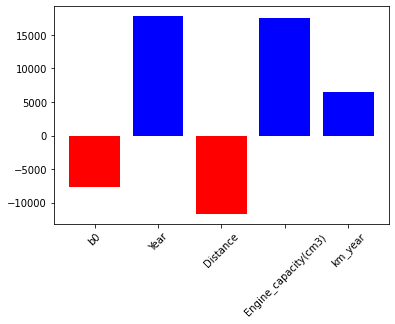

In [ ]:
#@title Регуляризация Ridge { run: "auto" }
#@markdown ### Константа Регуларизации
alpha=249.01 #@param {type:"slider", min:0.01, max:250, step:1}

model = Ridge(alpha=alpha,max_iter=10000 )

model.fit(X_train, y_train)

B0=model.intercept_
B=model.coef_

line='{:.2f}'.format(B0)
sign=['+','-']

features_names = df_num.drop(columns = ['Price(euro)']).columns
for p,(fn,b) in enumerate(zip(features_names,B)):
  if np.abs(b)>0:
    line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

print('Решение')
print(line)
print('\n')

y_predict=model.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('R2 : %.4f' %  r2_score(y_test,y_predict))

weights_vis(B, B0, features_names)

## Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска

In [ ]:
alpha_range = loguniform(1e-4, 1e4)

tuned_parameters = [{'alpha':  alpha_range }]

n_iter_search = 25

Ridge_search = RandomizedSearchCV(estimator = Ridge(max_iter=10000 ), verbose = 3,
                          param_distributions=tuned_parameters ,
                          cv=ShuffleSplit(n_splits=5, random_state=42),n_iter = n_iter_search)

Ridge_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...........alpha=4.354784014297236;, score=0.483 total time=   0.0s
[CV 2/5] END ...........alpha=4.354784014297236;, score=0.516 total time=   0.0s
[CV 3/5] END ...........alpha=4.354784014297236;, score=0.477 total time=   0.0s
[CV 4/5] END ...........alpha=4.354784014297236;, score=0.492 total time=   0.0s
[CV 5/5] END ...........alpha=4.354784014297236;, score=0.524 total time=   0.0s
[CV 1/5] END ...........alpha=0.984376619054871;, score=0.483 total time=   0.0s
[CV 2/5] END ...........alpha=0.984376619054871;, score=0.517 total time=   0.0s
[CV 3/5] END ...........alpha=0.984376619054871;, score=0.477 total time=   0.0s
[CV 4/5] END ...........alpha=0.984376619054871;, score=0.493 total time=   0.0s
[CV 5/5] END ...........alpha=0.984376619054871;, score=0.524 total time=   0.0s
[CV 1/5] END ..........alpha=3.8911444042896117;, score=0.483 total time=   0.0s
[CV 2/5] END ..........alpha=3.8911444042896117

In [ ]:
Ridge_best=Ridge_search.best_estimator_
Ridge_best

Ridge(alpha=0.0006111786669193699, max_iter=10000)

In [ ]:
Ridge_best.fit(X_train, y_train);

Посмотрим на результаты

In [ ]:
DF_Ridge=pd.DataFrame(Ridge_search.cv_results_)

Оставим минимум информации

In [ ]:
DF_ = DF_Ridge[['param_alpha',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("green", as_cmap=True)
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

Ну или

In [ ]:
from sklearn.linear_model import RidgeCV

## Поиск с помощью поиска по сетке

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
alpha_range = 10**np.linspace(-4, 4,15)

tuned_parameters = [{'alpha':  alpha_range }]

Ridge_search_ = GridSearchCV(estimator = Ridge(max_iter=10000 ), verbose = 3,
                          param_grid=tuned_parameters ,
                          cv=ShuffleSplit(n_splits=5, random_state=42))

Ridge_search_.fit(X_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ......................alpha=0.0001;, score=0.483 total time=   0.0s
[CV 2/5] END ......................alpha=0.0001;, score=0.517 total time=   0.0s
[CV 3/5] END ......................alpha=0.0001;, score=0.478 total time=   0.0s
[CV 4/5] END ......................alpha=0.0001;, score=0.493 total time=   0.0s
[CV 5/5] END ......................alpha=0.0001;, score=0.524 total time=   0.0s
[CV 1/5] END .......alpha=0.0003727593720314938;, score=0.483 total time=   0.0s
[CV 2/5] END .......alpha=0.0003727593720314938;, score=0.517 total time=   0.0s
[CV 3/5] END .......alpha=0.0003727593720314938;, score=0.478 total time=   0.0s
[CV 4/5] END .......alpha=0.0003727593720314938;, score=0.493 total time=   0.0s
[CV 5/5] END .......alpha=0.0003727593720314938;, score=0.524 total time=   0.0s
[CV 1/5] END .......alpha=0.0013894954943731374;, score=0.483 total time=   0.0s
[CV 2/5] END .......alpha=0.0013894954943731374;

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Ridge(max_iter=10000),
             param_grid=[{'alpha': array([1.00000000e-04, 3.72759372e-04, 1.38949549e-03, 5.17947468e-03,
       1.93069773e-02, 7.19685673e-02, 2.68269580e-01, 1.00000000e+00,
       3.72759372e+00, 1.38949549e+01, 5.17947468e+01, 1.93069773e+02,
       7.19685673e+02, 2.68269580e+03, 1.00000000e+04])}],
             verbose=3)

In [ ]:
Ridge_best=Ridge_search_.best_estimator_
Ridge_best

Ridge(alpha=0.0001, max_iter=10000)

In [ ]:
Ridge_best.fit(X_train, y_train);

Посмотрим на результаты

In [ ]:
DF_Ridge=pd.DataFrame(Ridge_search_.cv_results_)

Оставим минимум информации

In [ ]:
DF_ = DF_Ridge[['param_alpha',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("blue", as_cmap=True)
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

# Контрольные вопросы